In [1]:
import sys
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
import pickle

sys.dont_write_bytecode = True
from src.utils.utils import *
from src.features.build_features import *
from src.models.predict_model import *
from src.models.train_model import *
from src.visualization.visualize import *

from src.utils.constants import *

In [2]:
paths = [
    EXTERNAL_DATA_PATH,
    INTERIM_DATA_PATH,
    PROCESSED_DATA_PATH,
    os.path.dirname(GROUND_TRUTH_PATH),
    os.path.dirname(GROUND_TRUTH_SUMMARY),
    FIGURE_PATH
]

for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

# Settings

# Data inspection

In [3]:
# Ground truth summary

ground_truth_threshold = pd.read_parquet(GROUND_TRUTH_SUMMARY)

gtt_df = pd.DataFrame(ground_truth_threshold.loc[0])
gtt_df.T

,crypto,positive_Threshold,negative_Threshold,label,percentage
0,BTC,0.000343,-0.00034,"[positive, neutral, negative]","[15.497202877040758, 68.96639646839441, 15.536..."


In [4]:
# Ground truth
print("Ground truth")

ground_truth = pd.read_parquet(GROUND_TRUTH_PATH)
print("Length:", len(ground_truth))

ground_truth_features = [x for x in ground_truth.columns]
print("Features", ground_truth_features)

# Ground truth null values

ground_truth_null = ground_truth.loc[ground_truth['null'] == True]

print(f"Date range: {ground_truth['origin_time'].min()} - {ground_truth['origin_time'].max()}")
print(f"Null values length: {len(ground_truth_null)}")

ground_truth = ground_truth.loc[ground_truth['null'] != True]
print(f"Ground truth new length: {len(ground_truth)}")

Ground truth
Length: 525540
Features ['origin_time', 'null', 'close', 'next_change', 'label']
Date range: 2022-10-01 00:59:00 - 2023-09-30 23:58:00
Null values length: 1439
Ground truth new length: 524101


In [5]:
# Data cleaning

ground_truth.drop(columns=['null', 'close', 'next_change'], inplace=True)
ground_truth.head(2)

,origin_time,label
0,2022-10-01 00:59:00,negative
1,2022-10-01 01:00:00,neutral


In [6]:
# Exchanges summary

data = {}

summary_data = []

for exchange in EXCHANGES:
    candles_path = os.path.join(EXTERNAL_DATA_PATH, f'BTC-{exchange}_candles.parquet')
    orderbooks_path = os.path.join(EXTERNAL_DATA_PATH, f'BTC-{exchange}_orderbook.parquet')
    
    data[(exchange, CANDLES)] = pd.read_parquet(candles_path)
    data[(exchange, ORDERBOOK)] = pd.read_parquet(orderbooks_path)
    
    summary_data.append({
        'Exchange': exchange,
        'Candles Length': len(data[(exchange, CANDLES)]),
        'Candles Date Range Start': data[(exchange, CANDLES)]['origin_time'].min(),
        'Candles Date Range End': data[(exchange, CANDLES)]['origin_time'].max(),
        'Orderbook Length': len(data[(exchange, ORDERBOOK)]),
        'Orderbook Date Range Start': data[(exchange, ORDERBOOK)]['origin_time'].min(),
        'Orderbook Date Range End': data[(exchange, ORDERBOOK)]['origin_time'].max(),
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Exchange,Candles Length,Candles Date Range Start,Candles Date Range End,Orderbook Length,Orderbook Date Range Start,Orderbook Date Range End
0,BINANCE,525541,2022-10-01 00:59:00,2023-09-30 23:59:00,479971,2022-11-01 16:29:00,2023-09-30 23:59:00
1,HUOBI,405542,2022-12-23 08:58:00,2023-09-30 23:59:00,393120,2023-01-01 00:00:00,2023-09-30 23:59:00
2,OKX,405554,2022-12-23 08:46:00,2023-09-30 23:59:00,393120,2023-01-01 00:00:00,2023-09-30 23:59:00


In [7]:
# Datasets features

first_candles_key = list(data.keys())[0]
first_orderbooks_key = list(data.keys())[1]

candles_fetures = get_features(data[first_candles_key])
print(f"Candles features len:\t{len(candles_fetures)}\n{candles_fetures}")
orderbook_features = get_features(data[first_orderbooks_key])
print(f"Orderbooks features len:\t{len(orderbook_features)}\n{orderbook_features}")

Candles features len:	26
['origin_time', 'open', 'high', 'low', 'close', 'volume', 'trades', 'SMA_60', 'SMA_30', 'SMA_15', 'SMA_5', 'EMA_60', 'EMA_30', 'EMA_15', 'EMA_5', 'RSI_14', 'STOCH_H', 'MACD_H', 'BBL_20_2', 'BBM_20_2', 'BBH_20_2', 'MOM_10', 'CMO_9', 'ULTOSC', 'KAMA_30', 'null']
Orderbooks features len:	82
['origin_time', 'bid_0_price', 'bid_0_size', 'bid_1_price', 'bid_1_size', 'bid_2_price', 'bid_2_size', 'bid_3_price', 'bid_3_size', 'bid_4_price', 'bid_4_size', 'bid_5_price', 'bid_5_size', 'bid_6_price', 'bid_6_size', 'bid_7_price', 'bid_7_size', 'bid_8_price', 'bid_8_size', 'bid_9_price', 'bid_9_size', 'bid_10_price', 'bid_10_size', 'bid_11_price', 'bid_11_size', 'bid_12_price', 'bid_12_size', 'bid_13_price', 'bid_13_size', 'bid_14_price', 'bid_14_size', 'bid_15_price', 'bid_15_size', 'bid_16_price', 'bid_16_size', 'bid_17_price', 'bid_17_size', 'bid_18_price', 'bid_18_size', 'bid_19_price', 'bid_19_size', 'ask_0_price', 'ask_0_size', 'ask_1_price', 'ask_1_size', 'ask_2_price

In [8]:
# Null values summary

candles_summary = []
orderbooks_summary = []

for (exchange, data_type), df in data.items():
    if data_type == CANDLES:
        dataset_df_summary = get_dataframe_null_summary(df, exchange)
        candles_summary.append(dataset_df_summary)
    elif data_type == ORDERBOOK:
        dataset_df_summary = get_dataframe_null_summary(df, exchange)
        orderbooks_summary.append(dataset_df_summary)

display(pd.DataFrame(candles_summary))
display(pd.DataFrame(orderbooks_summary))

,Exchange,Total Entries,Null Entries,Null Percentage (%),origin_time,open,high,low,close,volume,...,STOCH_H,MACD_H,BBL_20_2,BBM_20_2,BBH_20_2,MOM_10,CMO_9,ULTOSC,KAMA_30,null
0,BINANCE,525541,2600,0.00495,0,0,0,0,0,2837,...,0,0,0,0,0,3492,2251,2727,0,522941
1,HUOBI,405542,4,0.00001,0,0,0,0,0,1222,...,16,0,0,0,0,827,0,0,0,405538
2,OKX,405554,1408,0.00347,0,0,0,0,0,1572,...,0,0,0,0,0,2975,1069,1424,0,404146


,Exchange,Total Entries,Null Entries,Null Percentage (%),origin_time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,...,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,null
0,BINANCE,479971,2739,0.00571,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,477232
1,HUOBI,393120,54316,0.13817,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,338804
2,OKX,393120,934,0.00238,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,392186


# Preprocessing

In [9]:
for (exchange, data_type), df in data.items():
    display(df.head(2))

,origin_time,open,high,low,close,volume,trades,SMA_60,SMA_30,SMA_15,...,STOCH_H,MACD_H,BBL_20_2,BBM_20_2,BBH_20_2,MOM_10,CMO_9,ULTOSC,KAMA_30,null
0,2022-10-01 00:59:00,19389.949219,19402.890625,19388.789062,19402.880859,97.72231,1360,19420.161816,19390.319466,19384.258594,...,4.654771,4.225298,19353.981577,19384.593359,19415.205142,21.361328,16.449292,62.816524,19404.818674,False
1,2022-10-01 01:00:00,19401.839844,19402.880859,19384.980469,19390.060547,171.99713,1665,19419.762500,19388.869141,19385.421354,...,-2.218688,3.586515,19354.827081,19383.719922,19412.612763,8.179688,-0.993919,57.319306,19404.465252,False


,origin_time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,bid_3_size,bid_4_price,...,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,null
0,2022-11-01 16:29:00,20430.31,0.45928,20430.30,0.01700,20430.28,0.75656,20430.25,0.01019,20430.20,...,0.33599,20432.49,0.59007,20432.50,0.01033,20432.51,0.49064,20432.52,0.07531,False
1,2022-11-01 16:30:00,20437.44,0.00581,20437.14,0.16832,20437.08,0.53340,20437.07,0.01980,20437.04,...,0.08021,20439.53,0.20421,20439.54,0.05700,20439.56,0.03428,20439.70,0.02273,False


,origin_time,open,high,low,close,volume,trades,SMA_60,SMA_30,SMA_15,...,STOCH_H,MACD_H,BBL_20_2,BBM_20_2,BBH_20_2,MOM_10,CMO_9,ULTOSC,KAMA_30,null
0,2022-12-23 08:58:00,16832.74,16832.75,16826.12,16827.83,1.610151,88,16833.9635,16834.492000,16836.926,...,-18.01157,-1.063314,16829.158436,16836.8685,16844.578564,-10.3,-43.670269,30.492535,16832.870645,False
1,2022-12-23 08:59:00,16827.82,16833.64,16827.81,16833.64,2.309176,79,16833.7815,16834.658333,16836.904,...,-12.47351,-0.991988,16829.329450,16836.9255,16844.521550,-8.9,-8.828931,46.130679,16832.880000,False


,origin_time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,bid_3_size,bid_4_price,...,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,null
0,2023-01-01 00:00:00,16540.99,0.770922,16540.75,0.300000,16540.71,0.056112,16540.13,0.725767,16540.12,...,2.702179,16547.21,0.09068,16547.30,0.031625,16547.31,0.022527,16547.52,0.200,False
1,2023-01-01 00:01:00,16539.29,0.565650,16539.04,0.006046,16538.80,0.006046,16538.56,0.006046,16538.31,...,0.360000,16542.21,0.24000,16542.45,0.040000,16542.55,0.080000,16542.96,0.236,False


,origin_time,open,high,low,close,volume,trades,SMA_60,SMA_30,SMA_15,...,STOCH_H,MACD_H,BBL_20_2,BBM_20_2,BBH_20_2,MOM_10,CMO_9,ULTOSC,KAMA_30,null
0,2022-12-23 08:46:00,16841.8,16841.8,16841.2,16841.2,0.318745,31,16841.055000,16836.5,16839.36,...,-3.730738,0.713263,16831.350282,16838.45,16845.549718,3.4,12.086986,58.245871,16834.101427,False
1,2022-12-23 08:47:00,16841.3,16841.3,16841.2,16841.3,0.401436,17,16840.911667,16837.1,16839.68,...,-1.378751,0.548341,16831.545800,16838.69,16845.834200,3.4,12.802971,57.036327,16834.591311,False


,origin_time,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,bid_3_size,bid_4_price,...,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size,null
0,2023-01-01 00:00:00,16547.6,0.485728,16547.2,0.011894,16547.0,0.748344,16546.9,0.444408,16546.8,...,0.0040,16549.5,1.511300,16549.7,0.200000,16550.1,0.100000,16550.3,0.055259,False
1,2023-01-01 00:01:00,16544.3,0.550176,16544.2,0.006740,16543.9,0.010414,16543.8,0.530234,16543.7,...,1.5113,16548.1,0.191439,16548.4,0.285396,16548.5,0.713489,16548.7,0.457000,False


In [10]:
def add_lag_features(df, exchange, data_type, features, lags):
    for feature in features:
        for lag in LAGS:
            df[f'{feature}_lag_{lag}'] = data[(exchange, data_type)][feature].shift(lag)
    return data

In [15]:
# Add time and lag features

for (exchange, data_type), df in data.items():

    # Add time features
    df['hour'] = df['origin_time'].dt.hour
    df['day_of_week'] = df['origin_time'].dt.dayofweek
    df['day_of_month'] = df['origin_time'].dt.day
    df['month'] = df['origin_time'].dt.month

    # Cyclic representation of time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    if data_type == CANDLES:
        for lag in LAGS:
            df[f'prev_change_lag_{lag}'] = df['close'] - df['close'].shift(lag)

            df.dropna(inplace=True)
            
    data[(exchange, data_type)] = df
display(data[(exchange, CANDLES)].head(5))

,origin_time,open,high,low,close,volume,trades,SMA_60,SMA_30,SMA_15,...,day_of_month,month,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,prev_change_lag_1,prev_change_lag_2,prev_change_lag_3,prev_change_lag_4
10,2022-12-23 08:56:00,16844.2,16844.2,16841.5,16841.5,1.638198,43,16839.996667,16840.683333,16844.226667,...,23,12,0.866025,-0.500000,-0.433884,-0.900969,-2.7,-2.9,-3.6,-6.7
11,2022-12-23 08:57:00,16841.0,16841.1,16837.5,16839.2,5.618935,121,16839.720000,16840.773333,16843.833333,...,23,12,0.866025,-0.500000,-0.433884,-0.900969,-2.3,-5.0,-5.2,-5.9
12,2022-12-23 08:58:00,16839.2,16839.2,16832.2,16832.9,3.142625,518,16839.360000,16840.653333,16843.233333,...,23,12,0.866025,-0.500000,-0.433884,-0.900969,-6.3,-8.6,-11.3,-11.5
13,2022-12-23 08:59:00,16832.9,16837.0,16832.9,16837.0,3.285199,44,16839.111667,16840.666667,16842.913333,...,23,12,0.866025,-0.500000,-0.433884,-0.900969,4.1,-2.2,-4.5,-7.2
14,2022-12-23 09:00:00,16837.9,16842.4,16837.9,16842.4,1.657010,163,16838.890000,16840.993333,16842.946667,...,23,12,0.707107,-0.707107,-0.433884,-0.900969,5.4,9.5,3.2,0.9


In [16]:
scaled_data = {}

for (exchange, data_type), df in data.items():
    print(f"Exchange: {exchange} - {data_type} length: {len(df)}")

    # Remove null values, drop null feature

    df_non_null_values = df.loc[df['null'] != True]
    df_non_null_feature = df_non_null_values.drop(columns=['null'])
    
    print(f"Exchange: {exchange} - new {data_type} length: {len(df_non_null_feature)}")

    # Scale data
    
    df_no_origin_time = df_non_null_feature.drop(columns=['origin_time'])
    scaled_data[(exchange, data_type)] = standard_scale(df_no_origin_time)
    scaled_data[(exchange, data_type)]['origin_time'] = df_non_null_feature['origin_time']
    pd.DataFrame.to_parquet(scaled_data[(exchange, data_type)], os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_scaled.parquet"))

Exchange: BINANCE - candles length: 525527
Exchange: BINANCE - new candles length: 522927
Exchange: BINANCE - orderbook length: 479971
Exchange: BINANCE - new orderbook length: 477232
Exchange: HUOBI - candles length: 405528
Exchange: HUOBI - new candles length: 405524
Exchange: HUOBI - orderbook length: 393120
Exchange: HUOBI - new orderbook length: 338804
Exchange: OKX - candles length: 405540
Exchange: OKX - new candles length: 404132
Exchange: OKX - orderbook length: 393120
Exchange: OKX - new orderbook length: 392186


In [17]:
def evaluate_correlation(df, exchange, data_type):
    scaled_no_origin_time = df.drop(columns=['origin_time'])
    plot_correlation_matrix(data_type, exchange, scaled_no_origin_time.corr())

    highly_correlated_pairs = df.corr().unstack().sort_values(kind="quicksort", ascending=False)
    highly_correlated_pairs = highly_correlated_pairs[(highly_correlated_pairs != 1) & (highly_correlated_pairs > CORRELATION_THRESHOLD)]

    print("Highly correlated pairs:")
    display(pd.DataFrame(highly_correlated_pairs))

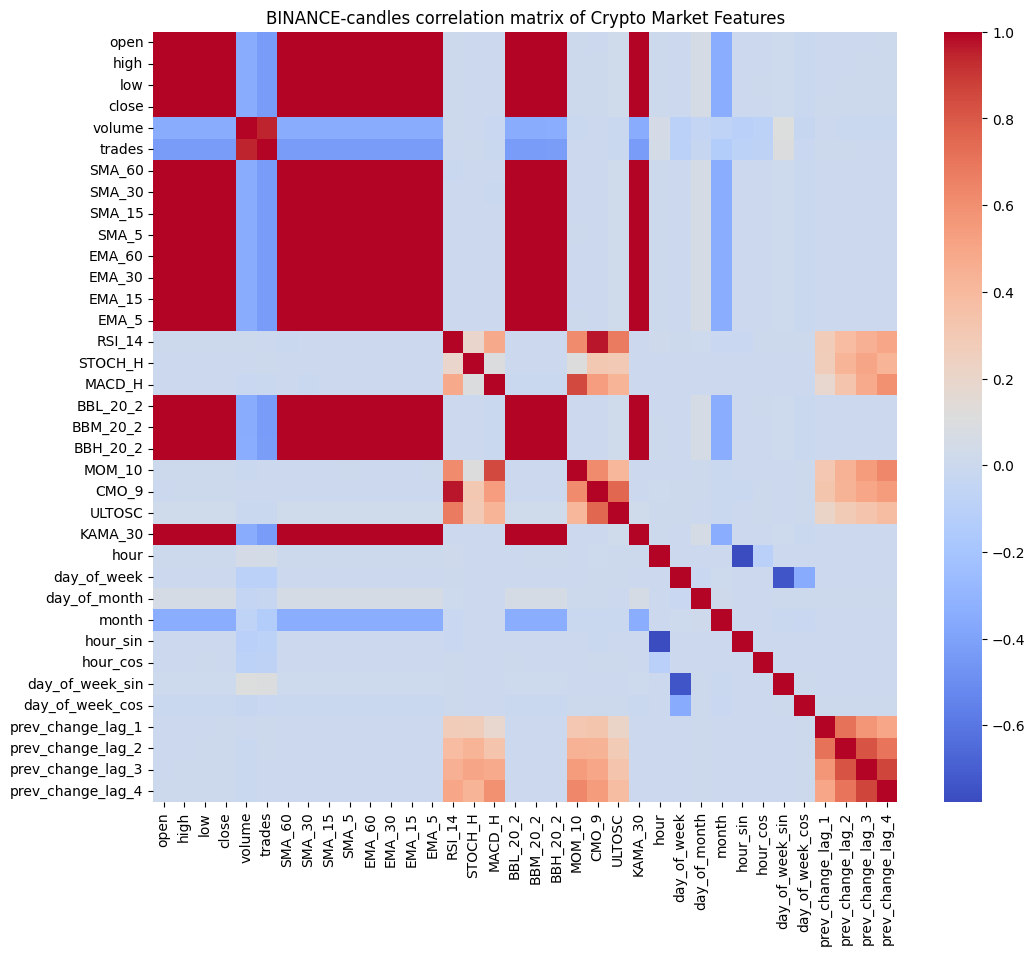

Highly correlated pairs:


,,0
EMA_5,SMA_5,1.000000
SMA_5,EMA_5,1.000000
SMA_15,EMA_15,0.999999
EMA_15,SMA_15,0.999999
BBM_20_2,SMA_15,0.999998
...,...,...
BBH_20_2,BBL_20_2,0.999857
RSI_14,CMO_9,0.971860
CMO_9,RSI_14,0.971860
volume,trades,0.947591


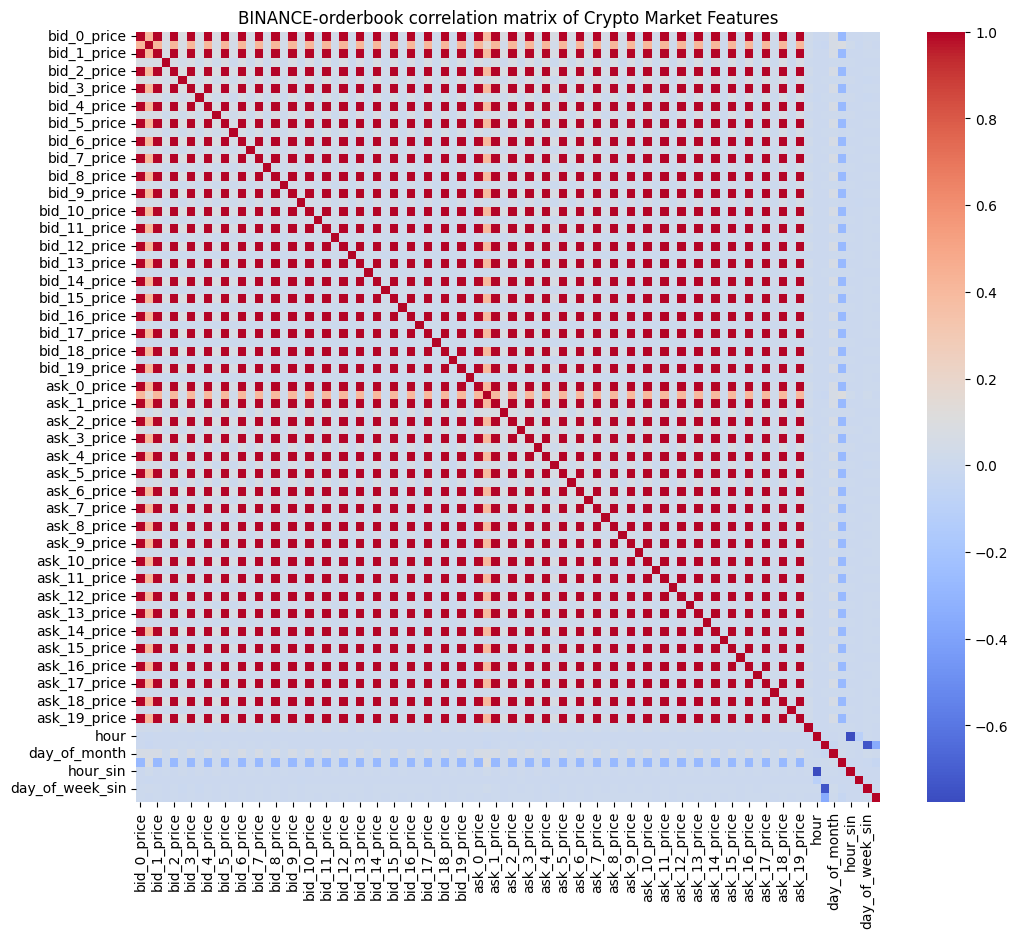

Highly correlated pairs:


,,0
ask_19_price,ask_18_price,1.0
ask_18_price,ask_19_price,1.0
bid_19_price,bid_18_price,1.0
bid_18_price,bid_19_price,1.0
ask_18_price,ask_17_price,1.0
...,...,...
bid_18_price,ask_19_price,1.0
ask_18_price,bid_19_price,1.0
bid_19_price,ask_18_price,1.0
ask_19_price,bid_19_price,1.0


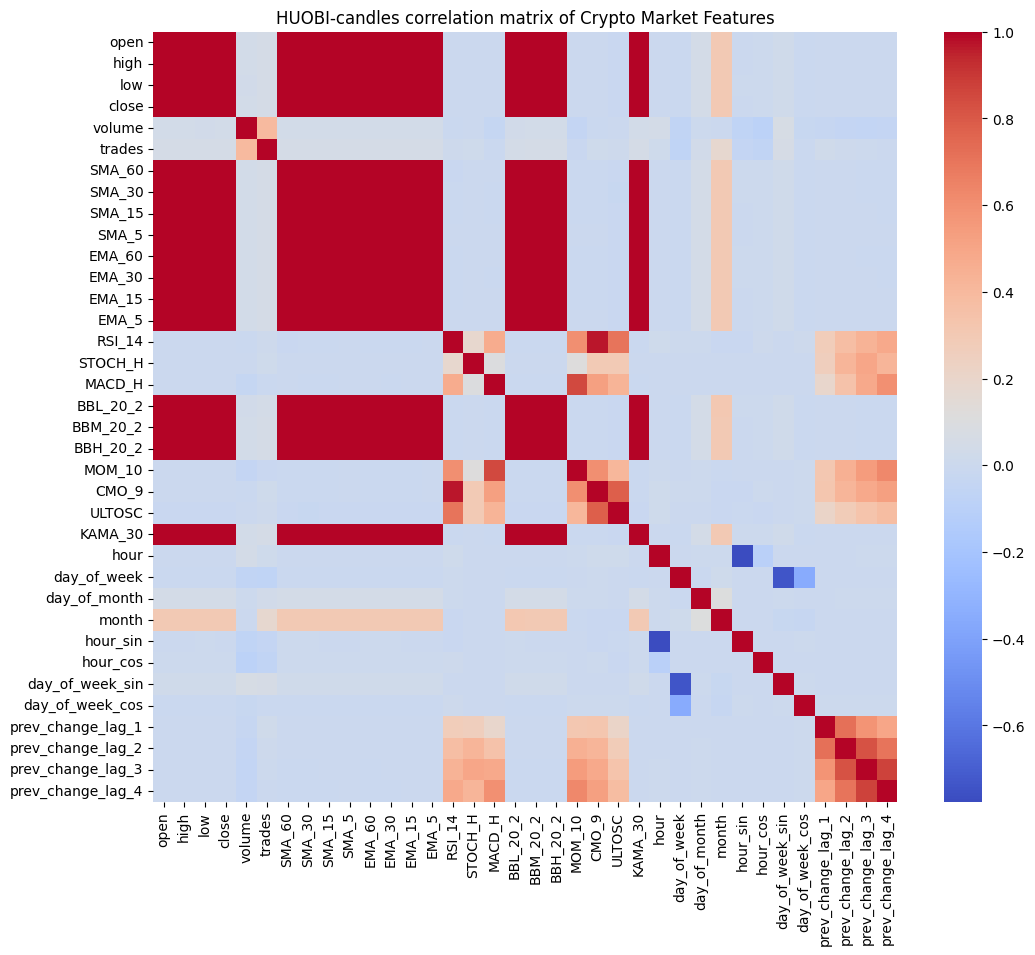

Highly correlated pairs:


0
EMA_5    SMA_5     0.999999
SMA_5    EMA_5     0.999999
EMA_15   SMA_15    0.999998
SMA_15   EMA_15    0.999998
         BBM_20_2  0.999997
...                     ...
low      SMA_60    0.999837
BBH_20_2 BBL_20_2  0.999758
BBL_20_2 BBH_20_2  0.999758
RSI_14   CMO_9     0.971596
CMO_9    RSI_14    0.971596

[242 rows x 1 columns]

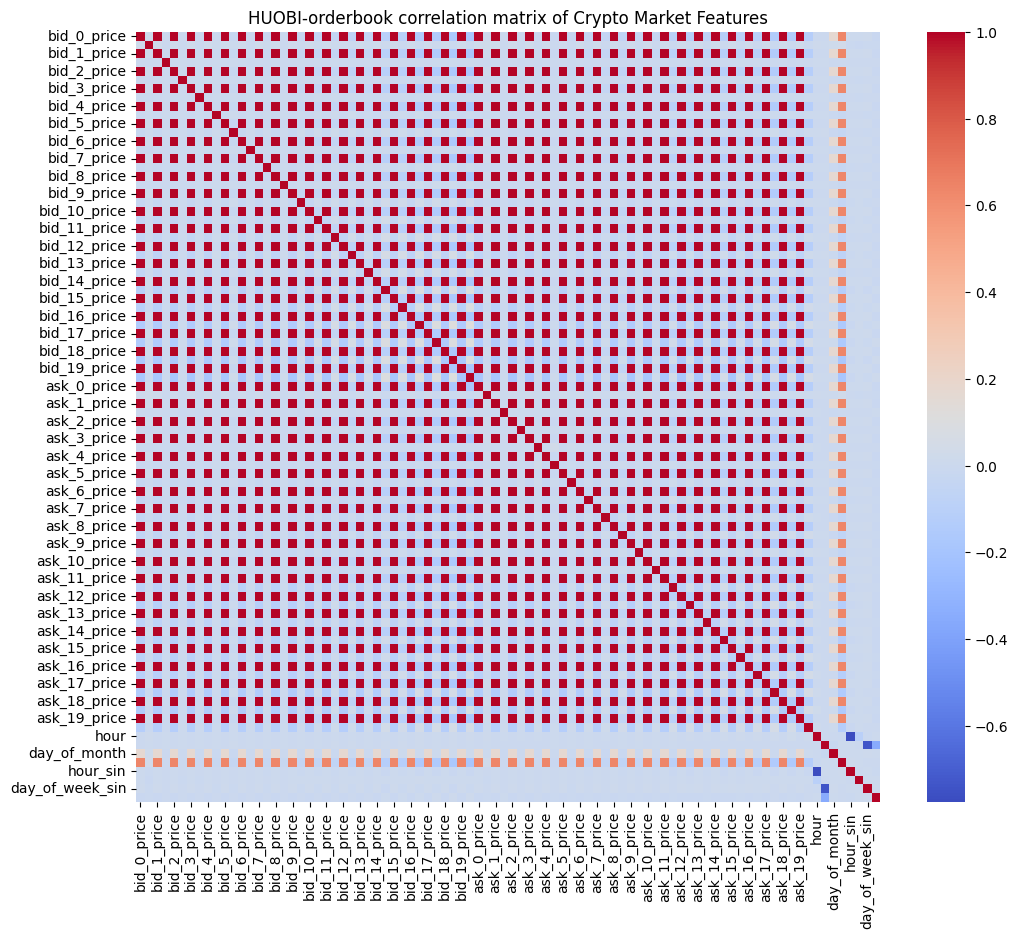

Highly correlated pairs:


0
ask_18_price ask_19_price  1.000000
ask_19_price ask_18_price  1.000000
ask_17_price ask_16_price  1.000000
ask_16_price ask_17_price  1.000000
             ask_15_price  1.000000
...                             ...
ask_18_price bid_19_price  0.999996
bid_19_price ask_19_price  0.999996
ask_19_price bid_19_price  0.999996
month        origin_time   0.994162
origin_time  month         0.994162

[1562 rows x 1 columns]

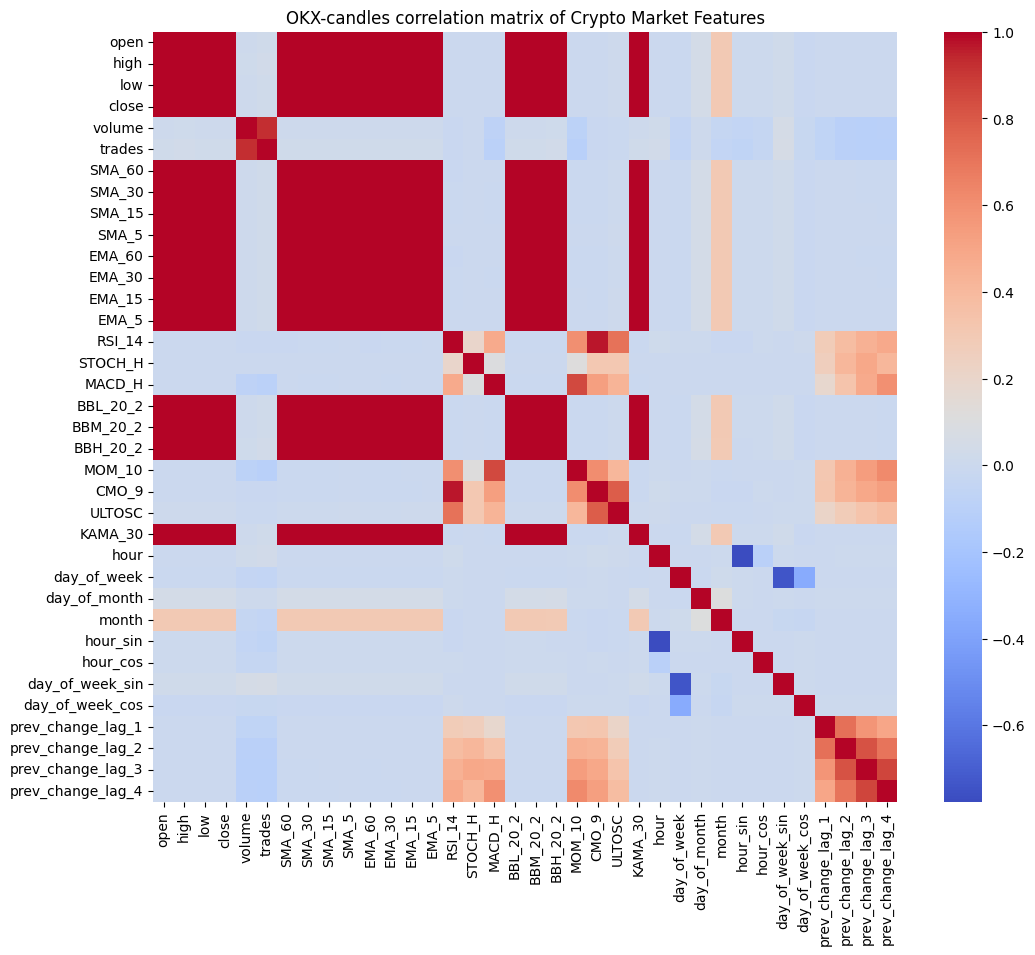

Highly correlated pairs:


,,0
SMA_5,EMA_5,0.999999
EMA_5,SMA_5,0.999999
SMA_15,EMA_15,0.999998
EMA_15,SMA_15,0.999998
SMA_15,BBM_20_2,0.999996
...,...,...
BBL_20_2,BBH_20_2,0.999744
RSI_14,CMO_9,0.971865
CMO_9,RSI_14,0.971865
trades,volume,0.927204


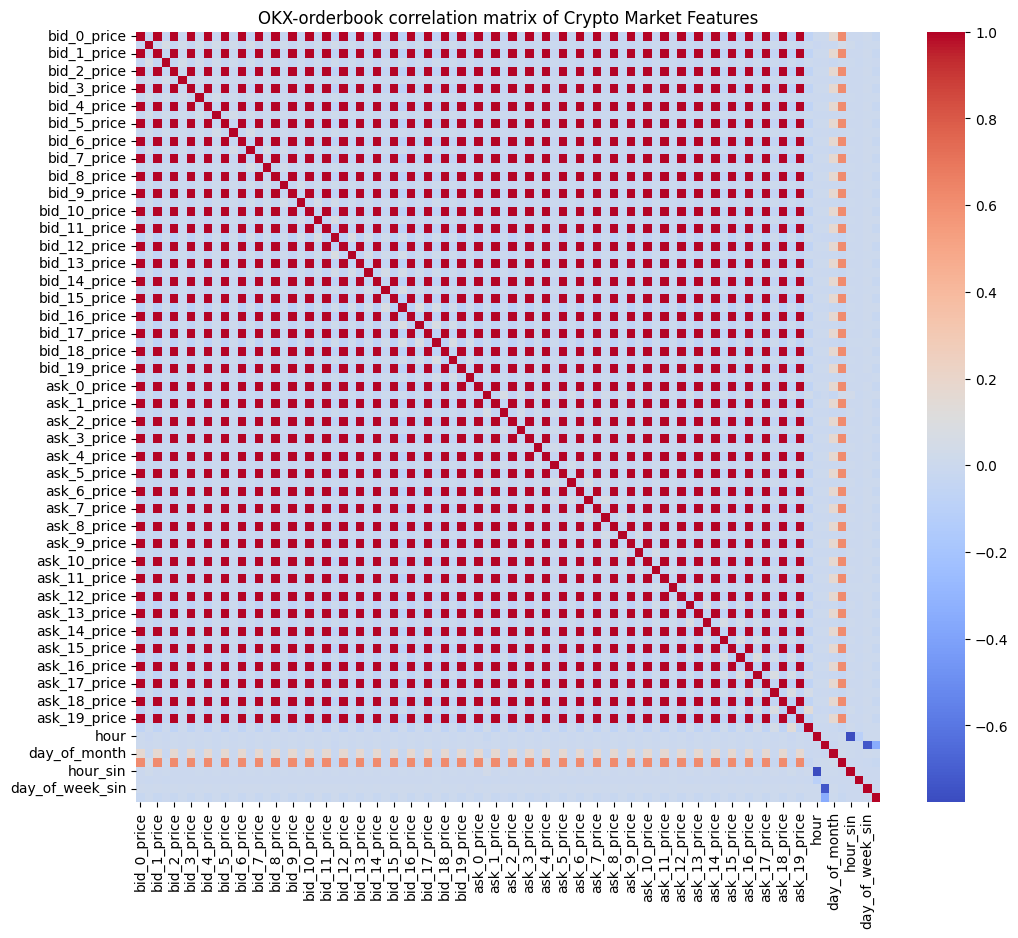

Highly correlated pairs:


,,0
ask_19_price,ask_18_price,1.000000
ask_18_price,ask_19_price,1.000000
bid_18_price,bid_19_price,1.000000
bid_19_price,bid_18_price,1.000000
ask_17_price,ask_18_price,1.000000
...,...,...
ask_18_price,bid_19_price,1.000000
ask_19_price,bid_19_price,1.000000
bid_19_price,ask_19_price,1.000000
month,origin_time,0.993789


In [18]:
# Evaluate data correlation

for (exchange, data_type), df in scaled_data.items():
    evaluate_correlation(df, exchange, data_type)

In [19]:
def compute_pca(df: pd.DataFrame, variance_threshold: float) -> tuple[PCA, np.array, np.array]:
    """Perform PCA and return the PCA object."""

    # Perform PCA
    pca = PCA()
    pca = pca.fit(df)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    # Get the number of components that explain the variance threshold
    num_components = np.where(cumulative_variance >= variance_threshold)[0][0] + 1
    pca_reduced = PCA(n_components=num_components).fit(df)
    
    return pca_reduced, explained_variance[:num_components], cumulative_variance[:num_components]

In [20]:
def compute_loadings(pca: PCA, df: pd.DataFrame) -> pd.DataFrame:
    """Compute the PCA loadings and return them as a DataFrame."""
    return pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df.columns)

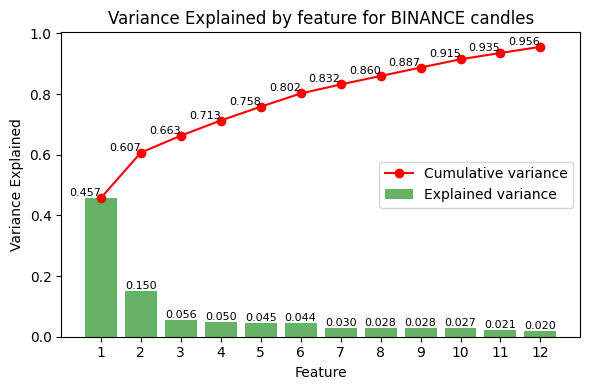

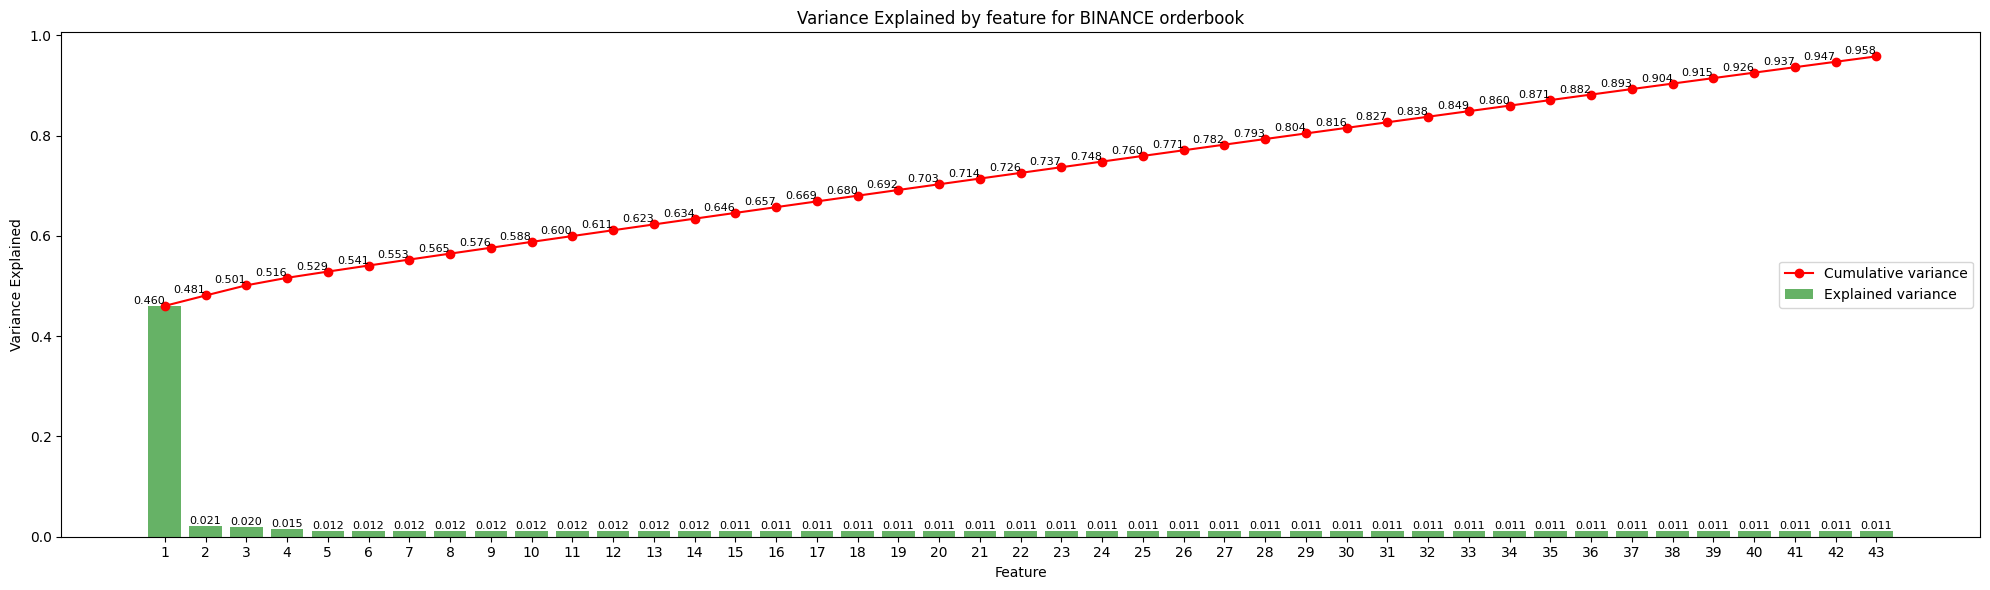

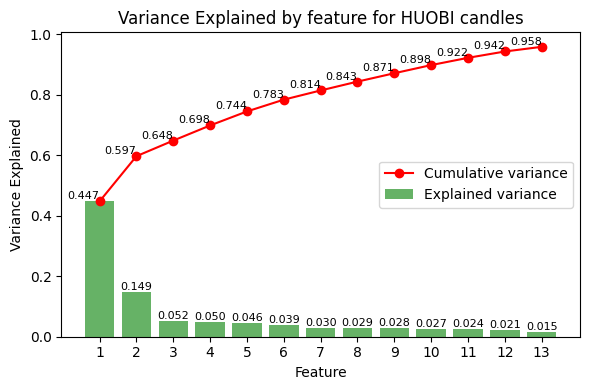

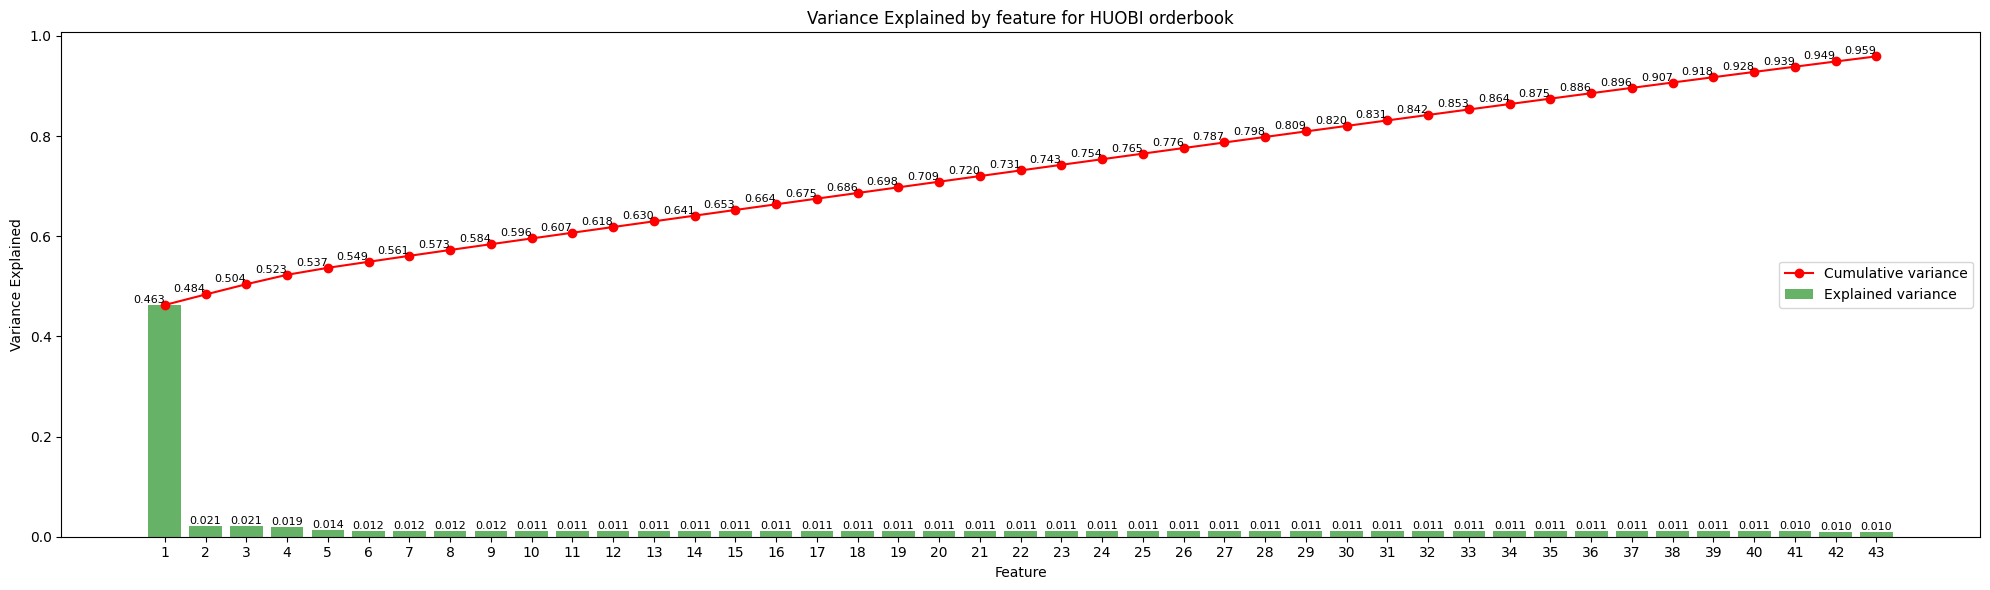

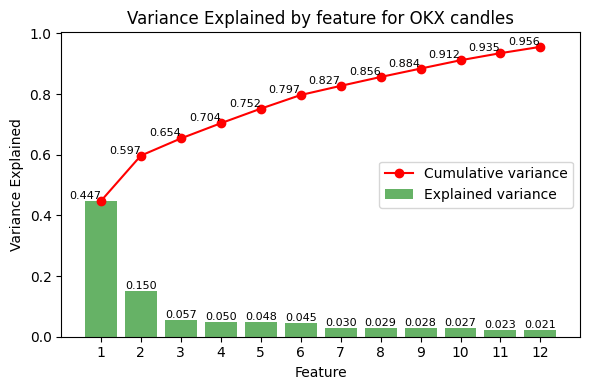

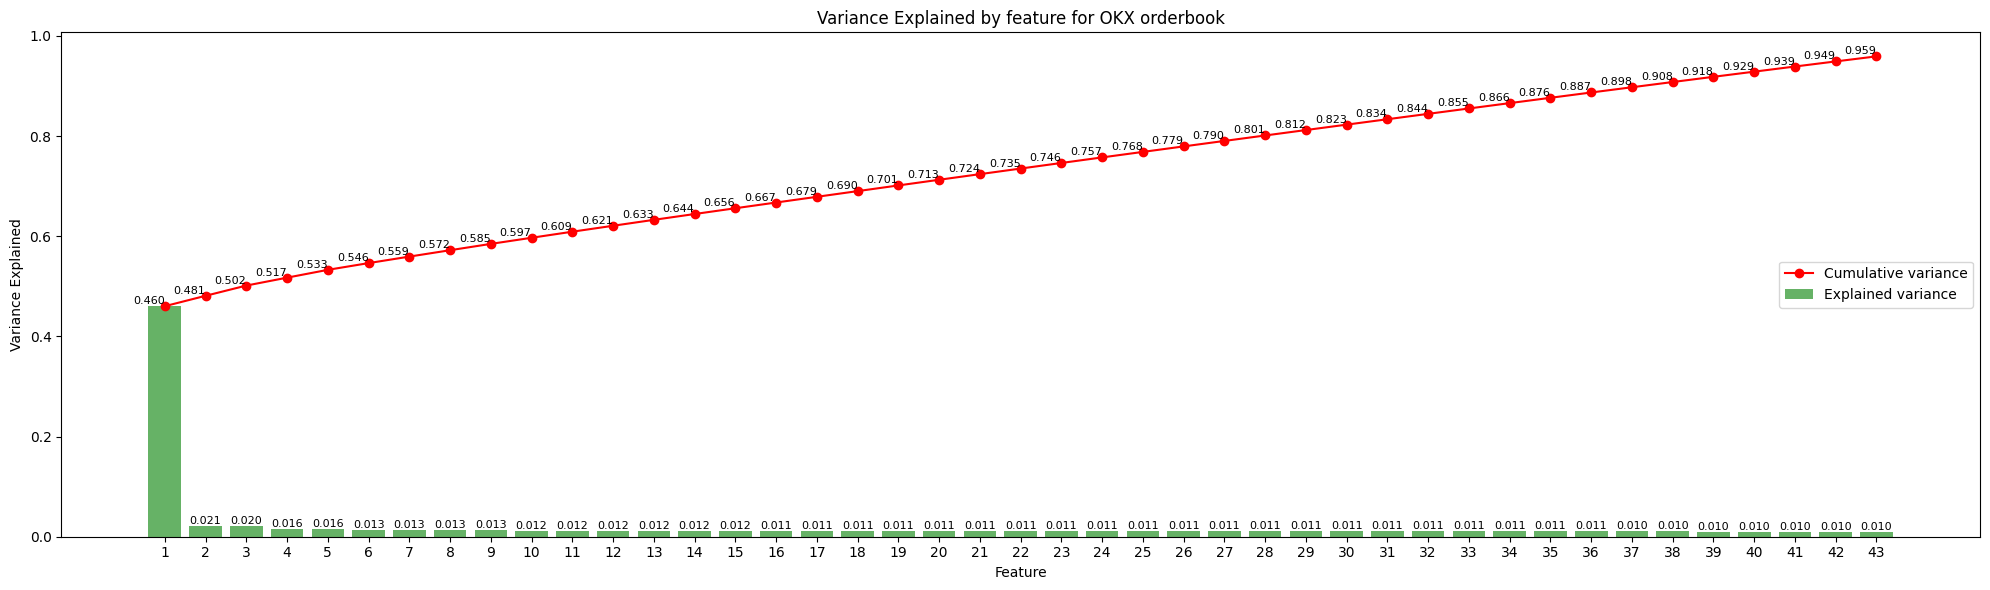

In [21]:
# PCA and explained variance

pca_data = {}
pca_loadings = {}

for (exchange, data_type), df in scaled_data.items():
    scaled_no_origin_time = df.drop(columns=['origin_time'])

    pca_fit, explained_variance, cumulative_variance = compute_pca(scaled_no_origin_time, PCA_VARIANCE_THRESHOLD)
    pca_loadings[(exchange, data_type)] = compute_loadings(pca_fit, scaled_no_origin_time)   

    pca_transformed = pca_fit.transform(scaled_no_origin_time)

    pca_df = pd.DataFrame(pca_transformed)
    pca_df.columns = [f"PC{i+1}" for i in range(pca_df.shape[1])]
    pca_df['origin_time'] = df['origin_time'].values

    pca_data[(exchange, data_type)] = pca_df

    pd.DataFrame.to_parquet(pca_data[(exchange, data_type)], os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_pca_data.parquet"))
    pd.DataFrame.to_parquet(df, os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_pca_loadings.parquet"))

    plot_feature_importance(data_type, exchange, explained_variance, cumulative_variance)
    

In [ ]:
def plot_learning_curves(estimator, X, y):
    """Plot learning curves for a given estimator."""
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [ ]:
def train_decision_tree_model(df: pd.DataFrame, param_grid) -> dict:
    """Train a Decision Tree model on the principal components with Stratified K-Fold cross-validation."""

    # Prepare the features and target variable
    X = df.drop(columns=['origin_time', 'label'])
    y = df['label']

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

    # Define the Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Initialize the Decision Tree model
    model = DecisionTreeClassifier(random_state=RANDOM_STATE)

    # Use GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Retrieve the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Parameters: {grid_search.best_params_}")
    print(f"Classification report:")
    display(report)
    print(f"Confusion matrix:")
    display(conf_matrix)
    
    plot_learning_curves(best_model, X_train, y_train)

    return {'best_model': best_model, 'best_params': best_params}

In [ ]:
# trained_models = {}

param_grid = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

for (exchange, data_type), df in pca_data.items():
    if exchange == BINANCE and data_type == CANDLES:

        print(f"Best Decision Tree model for {exchange} - {data_type}")
        results = train_decision_tree_model(df, param_grid)

        model_path = os.path.join(MODELS_DATA_PATH, f"{exchange}_{data_type}_DT.pkl")
        
        pickle.dump(results['best_model'], open(model_path, "wb"))
        pd.DataFrame.to_pickle(pd.DataFrame(results['best_params'], index=[0]), os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_DT_best_params.pkl"))

In [ ]:
# PCA loadings heatmap

for (exchange, data_type), df in pca_loadings.items():
    plot_loadings_heatmap(data_type, exchange, df)

In [ ]:
# Information gain

# information_gain = {}

# for (exchange, data_type), df in scaled_data.items():

#     merged_datasets = merge_datasets(ground_truth, df)
#     cols_to_drop = ['origin_time', 'label']

#     X = merged_datasets.drop(cols_to_drop, axis=1)

#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(merged_datasets['label'])

#     tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
#     tree_clf.fit(X, y_encoded)

#     feature_importances = tree_clf.feature_importances_
#     information_gain[(exchange, data_type)] = pd.DataFrame({'Feature': X.columns, 'Information_Gain': feature_importances}).sort_values(by='Information_Gain', ascending=False)

#     pd.DataFrame.to_parquet(information_gain[(exchange, data_type)], os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_information_gain.parquet"))

In [ ]:
# ig_sorted = {}
# threshold = 0.90

# for (exchange, data_type), df in information_gain.items():
#     df['Cumulative_IG'] = df['Information_Gain'].cumsum()

#     ig_sorted[(exchange, data_type)] = df.loc[df['Cumulative_IG'] <= threshold]

#     print(ig_sorted[(exchange, data_type)])
#     plot_feature_importance(data_type, exchange, df['Information_Gain'], df['Cumulative_IG'])

In [ ]:
# display(information_gain[(exchange, data_type)])

In [ ]:
# # Compare features scores
# ig = {}
# combined_scores = {}

# for (exchange, data_type), df in pca_loadings.items():
#     ig[(exchange, data_type)] = {}
#     for i in df.index:
#         ig[(exchange, data_type)][i] = information_gain[(exchange, data_type)].loc[information_gain[(exchange, data_type)]['Feature'] == i]['Information_Gain'].values[0]
#     display(ig[(exchange, data_type)])

In [ ]:
# for (exchange, data_type), df in combined_scores.items():
#     # plot_histogram_density(data_type, exchange, combined_scores[(exchange, data_type)], ['Loadings_Norm', 'Information_Gain', 'Combined_Scores'], ['blue', 'red', 'green'])
#     combined_scores_sorted = pd.DataFrame.sort_values(combined_scores[(exchange, data_type)], by='Combined_Scores', ascending=False)
#     display(combined_scores_sorted)
#     pd.DataFrame.to_parquet(combined_scores_sorted, os.path.join(INTERIM_DATA_PATH, f"{exchange}_{data_type}_combined_scores.parquet"))
    

In [ ]:
# combined_scores

In [ ]:
# for (data_type, exchange), df in combined_scores.items():
#     percentile_90 = np.percentile(df['Combined_Scores'], 80)

#     # Select features with scores above this percentile
#     selected_features = df[df['Combined_Scores'] >= percentile_90]
#     display(selected_features)

#     # Count the number of selected features
#     num_selected_features = selected_features.shape[0]

#     print(f"{exchange}-{data_type} - Number of selected features: {selected_features}")